## Evaluation


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use("seaborn-v0_8")

NOTEBOOK_DIR = Path.cwd()
ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "notebooks" else NOTEBOOK_DIR
DATA_PATH = ROOT / "Data" / "final_sentiment_dataset.csv"

df_raw = pd.read_csv(DATA_PATH, parse_dates=["Date"])
print(f"Loaded {len(df_raw)} rows from {DATA_PATH}")
print("Columns:", sorted(df_raw.columns.tolist()))
df_raw.head()

Loaded 81 rows from d:\Financial News Sentiment Analysis\Data\final_sentiment_dataset.csv
Columns: ['Adj Close', 'BB_lower', 'BB_middle', 'BB_upper', 'Close', 'Date', 'EMA_12', 'EMA_26', 'Headlines', 'Headlines_clean', 'High', 'Low', 'MACD', 'MACD_signal', 'Open', 'Price_change', 'Price_change_5d', 'RSI', 'SMA_10', 'SMA_20', 'SMA_5', 'Target', 'Volume', 'finbert_negative', 'finbert_neutral', 'finbert_positive', 'vader_compound']


,Date,Open,High,Low,Close,Adj Close,Volume,Headlines,Target,Headlines_clean,...,EMA_12,EMA_26,MACD,MACD_signal,RSI,BB_middle,BB_upper,BB_lower,Price_change,Price_change_5d
0,2020-06-09,83.035004,86.402496,83.002502,85.997498,83.889359,147712400,Why Apple's Stock Is Trading Higher Today Appl...,1,apple stock trading higher today apple could a...,...,85.997498,85.997498,0.000000,0.000000,NaN,85.997498,NaN,NaN,NaN,NaN
1,2020-06-09,126.472000,131.321503,126.250000,130.042999,130.042999,103520000,'Inside Amazon's plan to test warehouse worker...,1,inside amazon plan test warehouse worker covid...,...,130.042999,130.042999,0.000000,0.000000,NaN,130.042999,NaN,NaN,NaN,NaN
2,2011-05-23,38.970001,39.090000,38.700001,38.779999,38.779999,13400,American Drivers Should Thank European Voters,0,american driver thank european voter,...,38.779999,38.779999,0.000000,0.000000,NaN,38.779999,NaN,NaN,NaN,NaN
3,2011-06-08,37.889999,37.889999,37.040001,37.389999,37.389999,38900,The End of OPEC?,1,end opec,...,38.566153,38.677036,-0.110883,-0.022177,0.000000,38.084999,40.050755,36.119243,-0.035843,NaN
4,2011-07-01,39.889999,40.160000,39.459999,39.650002,39.650002,9100,Is China's Slowdown Bullish for the Global Eco...,1,china slowdown bullish global economy,...,38.732899,38.749107,-0.016209,-0.020983,61.917841,38.606667,40.886522,36.326811,0.060444,NaN


In [4]:

feature_cols = [
    "finbert_positive", "finbert_negative", "finbert_neutral",
    "vader_compound", "Open", "High", "Low", "Close", "Adj Close", "Volume", "SMA_5"
]


if isinstance(feature_cols, tuple):
    if len(feature_cols) == 1 and isinstance(feature_cols[0], list):
        feature_cols = feature_cols[0]
    else:
        feature_cols = list(feature_cols)

df = df_raw.copy()


if "Ticker" not in df.columns:
    df["Ticker"] = "TCKR"
    print("Info: 'Ticker' missing; filled with single label 'TCKR'.")


if "SMA_5" not in df.columns:
    df = df.sort_values(["Ticker", "Date"]).reset_index(drop=True)
    df["SMA_5"] = df.groupby("Ticker")['Close'].transform(lambda s: s.rolling(5, min_periods=1).mean())


if "Close" not in df.columns and "Adj Close" in df.columns:
    df["Close"] = df["Adj Close"]

available_features = [c for c in feature_cols if c in df.columns]
missing_target = "Target" not in df.columns
if missing_target:
    raise ValueError("Target column missing; rebuild dataset to include 'Target'.")

required_cols = available_features + ["Target"]
df_model = df.dropna(subset=required_cols).reset_index(drop=True)

X = df_model[available_features]
y = df_model["Target"].astype(int)

class_counts = y.value_counts()
use_stratify = class_counts.min() >= 2
test_size = 0.2 if len(y) > 30 else 0.33

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    shuffle=True,
    stratify=y if use_stratify else None,
    random_state=42,
 )



Info: 'Ticker' missing; filled with single label 'TCKR'.


Loading saved RandomForest model from d:\Financial News Sentiment Analysis\ml\serving\model.joblib
Saved RF accuracy: 0.47058823529411764
Classification Report (saved RF):
               precision    recall  f1-score   support

           0      0.000     0.000     0.000         7
           1      0.533     0.800     0.640        10

    accuracy                          0.471        17
   macro avg      0.267     0.400     0.320        17
weighted avg      0.314     0.471     0.376        17



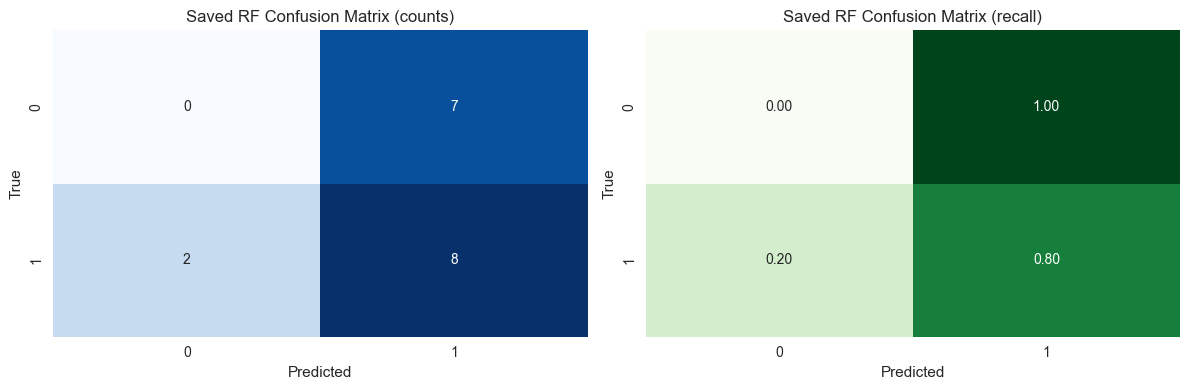

In [ ]:
# Evaluate using saved RandomForest model 
import joblib
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Confusion matrix 
labels_sorted = sorted(y.unique())

rf_path = ROOT / "ml" / "serving" / "model.joblib"
if rf_path.exists():
    print(f"Loading saved RandomForest model from {rf_path}")
    saved_rf = joblib.load(rf_path)

    try:
        feat_order = list(saved_rf.feature_names_in_)
    except Exception:
        feat_order = list(X_test.columns)
    X_test_rf = X_test[feat_order]
    y_pred_saved = saved_rf.predict(X_test_rf)
    print("Saved RF accuracy:", accuracy_score(y_test, y_pred_saved))
    print("Classification Report (saved RF):\n", classification_report(y_test, y_pred_saved, digits=3))
    cm_saved = confusion_matrix(y_test, y_pred_saved, labels=labels_sorted)
    cm_saved_norm = confusion_matrix(y_test, y_pred_saved, labels=labels_sorted, normalize='true')
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.heatmap(cm_saved, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
    axes[0].set_title("Saved RF Confusion Matrix (counts)")
    sns.heatmap(cm_saved_norm, annot=True, fmt=".2f", cmap="Greens", cbar=False, ax=axes[1])
    axes[1].set_title("Saved RF Confusion Matrix (recall)")
    for ax in axes:
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_xticklabels(labels_sorted)
        ax.set_yticklabels(labels_sorted)
    plt.tight_layout()
    plt.show()
else:
    print(f"No saved RandomForest model found at {rf_path}; using in-memory trained model.")
    # Reuse previously computed y_pred
    print("In-memory RF accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report (in-memory RF):\n", classification_report(y_test, y_pred, digits=3))

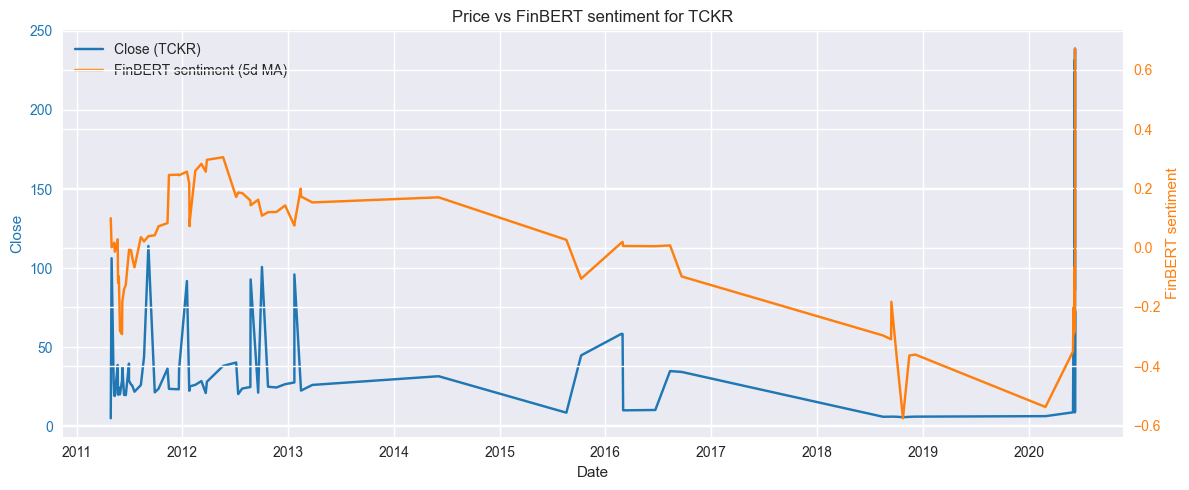

In [7]:
# Dual-axis plot: price vs FinBERT sentiment (per ticker)
price_col = "Close" if "Close" in df_model.columns else ("Adj Close" if "Adj Close" in df_model.columns else None)
required_sent_cols = ["finbert_positive", "finbert_negative"]
missing_sent_cols = [c for c in required_sent_cols if c not in df_model.columns]
if price_col is None:
    raise ValueError("No price column ('Close' or 'Adj Close') found in dataset.")
if missing_sent_cols:
    raise ValueError(f"Missing FinBERT columns: {missing_sent_cols}")

ticker_for_plot = df_model["Ticker"].mode().iat[0] if "Ticker" in df_model.columns else None
if ticker_for_plot is None:
    raise ValueError("Ticker column missing; cannot build per-ticker plot.")

plot_df = df_model[df_model["Ticker"] == ticker_for_plot].sort_values("Date").reset_index(drop=True)
if plot_df.empty:
    raise ValueError(f"No rows available for ticker {ticker_for_plot} to plot.")

plot_df = plot_df.copy()
plot_df["finbert_score"] = plot_df["finbert_positive"] - plot_df["finbert_negative"]
plot_df["finbert_score_smooth"] = plot_df["finbert_score"].rolling(5, min_periods=1).mean()

fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(plot_df["Date"], plot_df[price_col], color="tab:blue", label=f"{price_col} ({ticker_for_plot})")
ax1.set_ylabel(f"{price_col}", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(plot_df["Date"], plot_df["finbert_score_smooth"], color="tab:orange", label="FinBERT sentiment (5d MA)")
ax2.set_ylabel("FinBERT sentiment", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

ax1.set_title(f"Price vs FinBERT sentiment for {ticker_for_plot}")
ax1.set_xlabel("Date")
fig.tight_layout()

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
plt.show()

Loading LSTM model from d:\Financial News Sentiment Analysis\ml\serving\lstm_model.keras and prep from d:\Financial News Sentiment Analysis\ml\serving\lstm_prep.joblib
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
LSTM accuracy: 0.8
Classification Report (LSTM):
               precision    recall  f1-score   support

           0      0.000     0.000     0.000         3
           1      0.800     1.000     0.889        12

    accuracy                          0.800        15
   macro avg      0.400     0.500     0.444        15
weighted avg      0.640     0.800     0.711        15



d:\Financial News Sentiment Analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Financial News Sentiment Analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Financial News Sentiment Analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

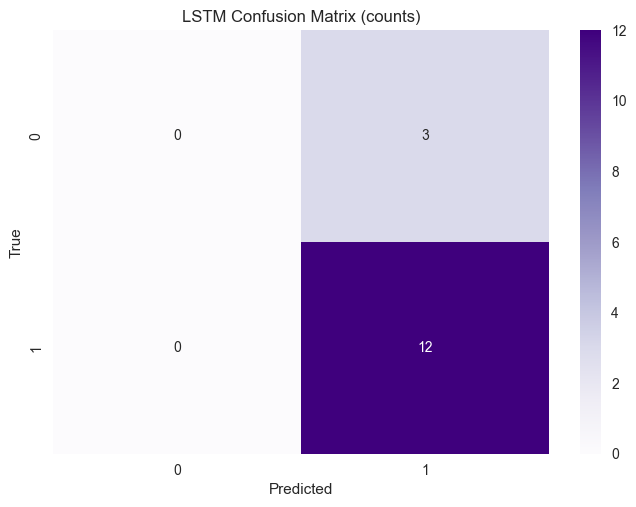

In [ ]:
# LSTM evaluation using saved Keras model + preprocessing
import joblib
from pathlib import Path
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

lstm_model_path = ROOT / "ml" / "serving" / "lstm_model.keras"
lstm_prep_path = ROOT / "ml" / "serving" / "lstm_prep.joblib"

if not lstm_model_path.exists() or not lstm_prep_path.exists():
    print(f"LSTM model or preprocessing not found at {lstm_model_path} / {lstm_prep_path}. Skipping LSTM evaluation.")
else:
    print(f"Loading LSTM model from {lstm_model_path} and prep from {lstm_prep_path}")
    lstm_model = tf.keras.models.load_model(lstm_model_path)
    prep = joblib.load(lstm_prep_path)
    scaler = prep.get("scaler")
    lstm_features = prep.get("features")
    SEQ_LEN = 7

    # Build sequences similarly to training notebook
    def build_sequences(dataframe, feature_cols, target_col, seq_len=SEQ_LEN):
        X_seq_all, y_seq_all = [], []
        for _, g in dataframe.groupby("Ticker"):
            g = g.sort_values("Date").reset_index(drop=True)
            if len(g) <= seq_len:
                continue
            feats = g[feature_cols].values
            target = g[target_col].values
            for i in range(len(g) - seq_len):
                end_idx = i + seq_len
                X_seq = feats[i:end_idx]
                y_val = target[end_idx]
                X_seq_all.append(X_seq)
                y_seq_all.append(y_val)
        return np.array(X_seq_all), np.array(y_seq_all)

    # Ensure features exist
    missing = [f for f in lstm_features if f not in df_model.columns]
    if missing:
        raise ValueError(f"Missing LSTM features in dataset: {missing}")

    seq_df = df_model.sort_values(["Ticker", "Date"]).reset_index(drop=True)
    seq_df_scaled = seq_df.copy()
    seq_df_scaled[lstm_features] = scaler.transform(seq_df_scaled[lstm_features])

    X_seq_all, y_seq_all = build_sequences(seq_df_scaled, lstm_features, "Target", seq_len=SEQ_LEN)
    # We'll split into train/test by the same logic: last 20% per ticker (simple approach here: split by index)
    split = int(len(X_seq_all) * 0.8)
    X_train_seq, X_test_seq = X_seq_all[:split], X_seq_all[split:]
    y_train_seq, y_test_seq = y_seq_all[:split], y_seq_all[split:]

    if len(X_test_seq) == 0:
        print("No sequence test data after split; cannot evaluate LSTM.")
    else:
        y_pred_prob = lstm_model.predict(X_test_seq)
        y_pred_label = (y_pred_prob.flatten() >= 0.5).astype(int)
        print("LSTM accuracy:", accuracy_score(y_test_seq, y_pred_label))
        print("Classification Report (LSTM):\n", classification_report(y_test_seq, y_pred_label, digits=3))
        cm_lstm = confusion_matrix(y_test_seq, y_pred_label)
        sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Purples")
        plt.title("LSTM Confusion Matrix (counts)")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()